In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas==1.3.5

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import time
from datetime import date
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import ceil
import os
from sys import exit
from datetime import datetime
import calendar    
import xgboost
import shap
import pickle


from itertools import groupby
from itertools import combinations
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import multiprocessing as mp
import warnings



class EMULATOR():
    
    def __init__(self, lat, lon, crop, location):


        self.today = date.today()
        self.location = location
        
        self.best_test_score = 0
        self.scores = []
        self.best_features = None
        
        self.lat = lat
        self.lon = lon
        self.base_yields =  Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W0_N200_A0.nc4')
        self.LONS = self.base_yields.variables['lon'][:]
        self.LATS = self.base_yields.variables['lat'][:]
        
        # lat and lon indices
        
        self.lon_ind = np.where(np.abs(self.LONS-self.lon) == np.min(np.abs(self.LONS - self.lon)))[0]
        self.lat_ind = np.where(np.abs(self.LATS-self.lat) == np.min(np.abs(self.LATS - self.lat)))[0]
  
        
        # Growing Season
        
        self.crop_file = Dataset(('/').join(['growing_season', crop + '_ggcmi_crop_calendar_phase3_v1.01.nc4'])) 
        self.pday = int(self.crop_file.variables['planting_day'][self.lat_ind[0],self.lon_ind[0]].data)
        self.gslength = int(self.crop_file.variables['growing_season_length'][self.lat_ind[0],self.lon_ind[0]].data)
        if self.pday == 0 or self.gslength == 0:
            raise Exception('No Crop Growing Season Data for this Location'+str(self.lat)+str(self.lon))
        
        self.full = list(range(self.pday,self.pday+self.gslength,1))
        self.planting_window = list(range(self.pday-5,self.pday+6,1))
        self.pre_anthesis = self.full[:ceil(len(self.full)/2) - 5]
        self.anthesis = self.full[ceil(len(self.full)/2)-5:
                ceil(len(self.full)/2)+5]
        self.post_anthesis = self.full[ceil(len(self.full)/2)+5:]
        
        
        # Yield Series
        
        self.yield_series = self.base_yields.variables[list(self.base_yields.variables.items())[3][0]][:,
                                             self.lat_ind[0],
                                             self.lon_ind[0]].reshape((31))
        
        # Precipitation, tas, tasmin and tasmax Series
        
        self.pr_series = Dataset('agmerra_1980-2010/pr_agmerra_1980-2010.nc4').variables['pr'][:,
                                                                                               self.lat_ind[0],
                                                                                               self.lon_ind[0]].reshape((11323))*86400
        self.tas_series = Dataset('agmerra_1980-2010/tas_agmerra_1980-2010.nc4').variables['tas'][:,
                                                                                               self.lat_ind[0],
                                                                                               self.lon_ind[0]].reshape((11323)) - 273.15
        self.tasmin_series = Dataset('agmerra_1980-2010/tasmin_agmerra_1980-2010.nc4').variables['tasmin'][:,
                                                                                               self.lat_ind[0],
                                                                                               self.lon_ind[0]].reshape((11323)) - 273.15
        self.tasmax_series = Dataset('agmerra_1980-2010/tasmax_agmerra_1980-2010.nc4').variables['tasmax'][:,
                                                                                               self.lat_ind[0],
                                                                                               self.lon_ind[0]].reshape((11323)) - 273.15
        
        

    def make_arrays(self):

        cnt = 0
        self.pr_array = np.empty((31,366),dtype='float16')
        self.pr_array[:] = np.nan
        self.tas_array = self.pr_array.copy()
        self.tasmin_array = self.pr_array.copy()
        self.tasmax_array = self.pr_array.copy()

        for year in range(31):
            if year in [0,4,8,12,16,20,24,28]:
                for day in range(366):
                    self.pr_array[year,day] = self.pr_series[cnt]
                    self.tas_array[year,day] = self.tas_series[cnt]
                    self.tasmin_array[year,day] = self.tasmin_series[cnt]
                    self.tasmax_array[year,day] = self.tasmax_series[cnt]
                    cnt += 1
            else:
                for day in range(365):
                    self.pr_array[year,day] = self.pr_series[cnt]
                    self.tas_array[year,day] = self.tas_series[cnt]
                    self.tasmin_array[year,day] = self.tasmin_series[cnt]
                    self.tasmax_array[year,day] = self.tasmax_series[cnt]
                    cnt += 1

        self.pr_array[self.pr_array == 0.00000000e+00] = np.nan

        self.pr_series = None
        self.tas_series = None
        self.tasmin_series = None
        self.tasmax_series = None
        
        if self.pday + self.gslength >= 365:
                                
            temp = np.concatenate((self.pr_array[1:,:],np.nanmedian(self.pr_array, axis=0).reshape((1,366)),), axis=0)
            self.pr_array = np.concatenate((self.pr_array, temp), axis=1)
            
            temp = np.concatenate((self.tas_array[1:,:],np.nanmedian(self.tas_array, axis=0).reshape((1,366)),), axis=0)
            self.tas_array = np.concatenate((self.tas_array, temp), axis=1)
            
            temp = np.concatenate((self.tasmin_array[1:,:],np.nanmedian(self.tasmin_array, axis=0).reshape((1,366)),), axis=0)
            self.tasmin_array = np.concatenate((self.tasmin_array, temp), axis=1)
            
            temp = np.concatenate((self.tasmax_array[1:,:],np.nanmedian(self.tasmax_array, axis=0).reshape((1,366)),), axis=0)
            self.tasmax_array = np.concatenate((self.tasmax_array, temp), axis=1)
            
            del temp
                    


    def max_consec_precip_below(self, arr, value):
        arr[np.isnan(arr)] = 0
        lens = []
        for k,g in groupby(np.diff([i for i, x in enumerate(arr) if x < value])):
            if k == 1:
                lens.append(len(list(g)))
        try:
            return max(lens)
        except:
            return 0

    def event_counts(self,arr, logic, value):
        
          """
          arr: array
          logic: 'greater","less","equal"
          value: value for logic
          """
          cnt = 0
          if logic == 'greater':
            for i in arr:
              if i > value:
                cnt+= 1
            return cnt
          if logic == 'less':
            for i in arr:
              if i < value:
                cnt+=1
            return cnt
          if logic == "equal":
            for i in arr:
              if i == value:
                cnt+=1
            return cnt
          return None



    
    def base_frame(self):
        
        event_counts = self.event_counts
        max_consec_precip_below = self.max_consec_precip_below


        
        full = self.full
        planting_window = self.planting_window
        pre_anthesis = self.pre_anthesis
        anthesis = self.anthesis
        post_anthesis = self.post_anthesis
        
        pr_array = self.pr_array
        tas_array = self.tas_array
        tasmax_array = self.tasmax_array 
        tasmin_array = self.tasmin_array 
        
        

        self.X = pd.DataFrame({'Mean P GS' : np.nanmean(pr_array[:,full], axis=1)})
        self.X['Mean P Planting Window'] = np.nanmean(pr_array[:,planting_window], axis=1)
        self.X['Mean P Pre-Anthesis'] = np.nanmean(pr_array[:,pre_anthesis], axis=1)
        self.X['Mean P Anthesis'] = np.nanmean(pr_array[:,anthesis], axis=1)
        self.X['Mean P Post-Anthesis'] = np.nanmean(pr_array[:,post_anthesis], axis=1)
        
        self.X['Count P Above 1mm GS'] = np.apply_along_axis(event_counts, 1, pr_array[:,full], 'greater', 1)
        self.X['Count P Above 1mm Planting Window'] = np.apply_along_axis(event_counts, 1, pr_array[:,planting_window], 'greater', 1)
        self.X['Count P Above 1mm Pre-Anthesis'] = np.apply_along_axis(event_counts, 1, pr_array[:,pre_anthesis], 'greater', 1)
        self.X['Count P Above 1mm Anthesis'] = np.apply_along_axis(event_counts, 1, pr_array[:,anthesis], 'greater', 1)
        self.X['Count P Above 1mm Post-Anthesis'] = np.apply_along_axis(event_counts, 1, pr_array[:,post_anthesis], 'greater', 1)
        
        self.X['Maximum Consecutive Days P < .01 GS'] = np.apply_along_axis(max_consec_precip_below, 1, pr_array[:,full], .01)
        self.X['Maximum Consecutive Days P < .01 Planting Window'] = np.apply_along_axis(max_consec_precip_below, 1, pr_array[:,self.planting_window], .01)
        self.X['Maximum Consecutive Days P < .01 Pre-Anthesis'] = np.apply_along_axis(max_consec_precip_below, 1, pr_array[:,pre_anthesis], .01)
        self.X['Maximum Consecutive Days P < .01 Anthesis'] = np.apply_along_axis(max_consec_precip_below, 1, pr_array[:,anthesis], .01)
        self.X['Maximum Consecutive Days P < .01 Post-Anthesis'] = np.apply_along_axis(max_consec_precip_below, 1, pr_array[:,post_anthesis], .01)
        
        self.X['Mean T GS'] = np.nanmean(tas_array[:,full], axis=1)
        self.X['Mean T Planting Window'] = np.nanmean(tas_array[:,planting_window], axis=1)
        self.X['Mean T Pre-Anthesis'] = np.nanmean(tas_array[:,pre_anthesis], axis=1)
        self.X['Mean T Anthesis'] = np.nanmean(tas_array[:,anthesis], axis=1)
        self.X['Mean T Post-Anthesis'] = np.nanmean(tas_array[:,post_anthesis], axis=1)
        
        self.X['Count T > 30 GS'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,full], 'greater', 30)
        self.X['Count T > 30 Planting Window'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,planting_window], 'greater', 30)
        self.X['Count T > 30 Pre-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,pre_anthesis], 'greater', 30)
        self.X['Count T > 30 Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,anthesis], 'greater', 30)
        self.X['Count T > 30 Post-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,post_anthesis], 'greater', 30)
        
        self.X['Count T > 35 GS'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,full], 'greater', 35)
        self.X['Count T > 35 Planting Window'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,planting_window], 'greater', 35)
        self.X['Count T > 35 Pre-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,pre_anthesis], 'greater', 35)
        self.X['Count T > 35 Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,anthesis], 'greater', 35)
        self.X['Count T > 35 Post-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmax_array[:,post_anthesis], 'greater', 35)
        
        self.X['Count T < 0 GS'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,full], 'less', 0)
        self.X['Count T < 0 Planting Window'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,planting_window], 'less', 0)
        self.X['Count T < 0 Pre-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,pre_anthesis], 'less', 0)
        self.X['Count T < 0 Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,anthesis], 'less', 0)
        self.X['Count T < 0 Post-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,post_anthesis], 'less', 0)
        
        self.X['Count T < 5 GS'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,full], 'less', 5)
        self.X['Count T < 5 Planting Window'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,planting_window], 'less', 5)
        self.X['Count T < 5 Pre-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,pre_anthesis], 'less', 5)
        self.X['Count T < 5 Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,anthesis], 'less', 5)
        self.X['Count T < 5 Post-Anthesis'] = np.apply_along_axis(event_counts, 1, tasmin_array[:,post_anthesis], 'less', 5)
        
        
        
        del full, planting_window, pre_anthesis, anthesis, post_anthesis
        del event_counts, max_consec_precip_below
        
    def data_generator(self, delta_temp=None, delta_precip=None):

        """
        This function will output two arrays:
        features: 31 by 40 numpy array corresponding to the 40 features perturbed by delta_temp and delta_precip

        Inputs: 
        delta_temp: float digit indicating a change in temperature of (-1,+1,+2,+3) degrees
        delta_precip: float decimal indicating a factor change in precip of (.80, .90, 1.1, 1.2) %


        If delta_temp and delta_precip == None, this corresponds to processing and feature engineering of original data.

        """

        features = np.empty((31,40),dtype='float16')
        
        
        event_counts = self.event_counts
        max_consec_precip_below = self.max_consec_precip_below

        
        full = self.full
        planting_window = self.planting_window
        pre_anthesis = self.pre_anthesis
        anthesis = self.anthesis
        post_anthesis = self.post_anthesis
        
        pr_array = self.pr_array
        tas_array = self.tas_array
        tasmin_array = self.tasmin_array
        tasmax_array = self.tasmax_array
        



        # Perturbations

        if delta_temp == None:
            pert_tas = tas_array.copy()
            pert_tasmin = tasmin_array.copy()
            pert_tasmax = tasmax_array.copy()

        else:
            pert_tas = tas_array + delta_temp
            pert_tasmin = tasmin_array + delta_temp
            pert_tasmax = tasmax_array + delta_temp

        if delta_precip == None:
            pert_precip = pr_array.copy()

        else:
            pert_precip = pr_array*delta_precip


        # Feature Extraction

        ## Mean P GS

        features[:,0] = np.nanmean(pert_precip[:,full], axis=1)

        ## Mean P Planting Window

        features[:,1] = np.nanmean(pert_precip[:,planting_window], axis=1)

        ## Mean P Pre Anthesis

        features[:,2] = np.nanmean(pert_precip[:,pre_anthesis], axis=1)

        ## Mean P Anthesis

        features[:,3] = np.nanmean(pert_precip[:,anthesis], axis=1)

        ## Mean P Post Anthesis

        features[:,4] = np.nanmean(pert_precip[:,post_anthesis], axis=1)

        ## Count P > 1mm/day GS

        features[:,5] = np.apply_along_axis(event_counts, 1, pert_precip[:, full], 'greater', 1)

        ## Count P > 1mm/day Planting Window

        features[:,6] = np.apply_along_axis(event_counts, 1, pert_precip[:, planting_window], 'greater', 1)

        ## Count P > 1mm/day Pre-Anthesis

        features[:,7] = np.apply_along_axis(event_counts, 1, pert_precip[:, pre_anthesis], 'greater', 1)

        ## Count P > 1mm/day Anthesis

        features[:,8] = np.apply_along_axis(event_counts, 1, pert_precip[:, anthesis], 'greater', 1)

        ## Count P > 1mm/day Post-Anthesis

        features[:,9] = np.apply_along_axis(event_counts, 1, pert_precip[:, post_anthesis], 'greater', 1)

        ## Maximum Consecutive P < .01 GS

        features[:,10] = np.apply_along_axis(max_consec_precip_below, 1, pert_precip[:,full], .01)

        ## Maximum Consecutive P < .01 Planting

        features[:,11] = np.apply_along_axis(max_consec_precip_below, 1, pert_precip[:,planting_window], .01)

        ## Maximum Consecutive P < .01 Pre

        features[:,12] = np.apply_along_axis(max_consec_precip_below, 1, pert_precip[:,pre_anthesis], .01)

        ## Maximum Consecutive P < .01 Anthesis

        features[:,13] = np.apply_along_axis(max_consec_precip_below, 1, pert_precip[:,anthesis], .01)

        ## Maximum Consecutive P < .01 Post

        features[:,14] = np.apply_along_axis(max_consec_precip_below, 1, pert_precip[:,post_anthesis], .01)

        ## Mean T GS

        features[:,15] = np.nanmean(pert_tas[:,full], axis=1)

        ## Mean T GS Planting

        features[:,16] = np.nanmean(pert_tas[:,planting_window], axis=1)

        ## Mean T GS Pre

        features[:,17] = np.nanmean(pert_tas[:,pre_anthesis], axis=1)

        ## Mean T GS Anthesis

        features[:,18] = np.nanmean(pert_tas[:,anthesis], axis=1)

        ## Mean T GS Post

        features[:,19] = np.nanmean(pert_tas[:,post_anthesis], axis=1)

        ## Count T > 30 GS

        features[:,20] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,full], 'greater', 30)

        ## Count T > 30 Planting

        features[:,21] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,planting_window], 'greater', 30)

        ## Count T > 30 Pre

        features[:,22] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,pre_anthesis], 'greater', 30)

        ## Count T > 30 Anthesis

        features[:,23] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,anthesis], 'greater', 30)

        ## Count T > 30 Post

        features[:,24] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,post_anthesis], 'greater', 30)

        ## Count T > 35 GS

        features[:,25] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,full], 'greater', 35)

        ## Count T > 35 Planting

        features[:,26] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,planting_window], 'greater', 35)

        ## Count T > 35 Pre

        features[:,27] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,pre_anthesis], 'greater', 35)

        ## Count T > 35 Anthesis

        features[:,28] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,anthesis], 'greater', 35)

        ## Count T > 35 Post

        features[:,29] = np.apply_along_axis(event_counts, 1, pert_tasmax[:,post_anthesis], 'greater', 35)

        ## Count T < 0 GS

        features[:,30] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,full], 'less', 0)

        ## Count T < 0 Planting

        features[:,31] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,planting_window], 'less', 0)

        ## Count T < 0  Pre

        features[:,32] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,pre_anthesis], 'less', 0)

        ## Count T < 0 Anthesis

        features[:,33] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,anthesis], 'less', 0)

        ## Count T < 0 Post

        features[:,34] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,post_anthesis], 'less', 0)

        ## Count T < 5 GS

        features[:,35] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,full], 'less', 5)

        ## Count T < 5 Planting

        features[:,36] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,planting_window], 'less', 5)

        ## Count T < 5 Pre

        features[:,37] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,pre_anthesis], 'less', 5)

        ## Count T < 5 Anthesis

        features[:,38] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,anthesis], 'less', 5)

        ## Count T < 5 Post

        features[:,39] = np.apply_along_axis(event_counts, 1, pert_tasmin[:,post_anthesis], 'less', 5)

        return features

    
    def complete_X(self):
        
        
        my_generator = self.data_generator
        
        temp_X = my_generator(-1,None)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W0_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(1,None)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T1_W0_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(2,None)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T2_W0_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(3,None)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T3_W0_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        
        temp_X = my_generator(None,.8)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W-20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(None,.9)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W-10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(None,1.1)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        
        temp_X = my_generator(None,1.2)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(-1,.8)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(-1,.9)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(-1,1.1)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(-1,1.2)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(1,.8)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T1_W-20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(1,.9)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T1_W-10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(1,1.1)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T1_W10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(1,1.2)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T1_W20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(2,.8)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T2_W-20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        temp_X = my_generator(2,.9)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T2_W-10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(2,1.1)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T2_W10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(2,1.2)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T2_W20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(3,.8)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T3_W-20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(3,.9)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T3_W-10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(3,1.1)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T3_W10_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        temp_X = my_generator(3,1.2)
        self.X = pd.concat([self.X, pd.DataFrame(temp_X,columns=self.X.columns)],
                    ignore_index=True)
        temp_yield_series = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T3_W20_N200_A0.nc4').variables[list(self.base_yields.variables.items())[3][0]][:,
                                                                                                                                              self.lat_ind[0],
                                                                                                                                              self.lon_ind[0]].reshape((31))
        
        self.yield_series = np.append(self.yield_series,temp_yield_series,axis=0)
        
        
        
        
        del temp_X, temp_yield_series
        self.X['Mean P Planting Window'] = self.X['Mean P Planting Window'].fillna(self.X['Mean P Planting Window'].median())
        self.X.fillna({ col : self.X[col].median() for col in self.X.columns}, inplace=True)


        
        
        
    def train(self, feature_test_score=dict, model=object): 
        
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                           self.yield_series,
                                                           test_size=0.33,
                                                           random_state=42,
                                                           shuffle=True)
        START = time.time()
        
        self.test_scores = feature_test_score
        self.model = model
        self.scores = []
        self.best_test_score = 0 
    
        myfile = open('LOGS/'+('_').join(['lat'+str(self.LATS[self.lat_ind][0]),'lon'+str(self.LONS[self.lon_ind][0]),str(self.today),'train_log.txt']), 'a')
        myfile.write((' ').join([self.location,'\n']))
        myfile.close()



        for i, (k,v) in enumerate(self.test_scores.items()):

        
            self.model.fit(X_train.loc[:,k].values,
                      y_train)


            this_test_score = self.model.score(X_test.loc[:,k], y_test)
            self.scores.append(this_test_score)
            self.test_scores[k] = this_test_score
            if this_test_score > self.best_test_score:

                self.best_test_score = this_test_score
                self.best_features = k
                myfile = open('LOGS/'+('_').join(['lat'+str(self.LATS[self.lat_ind][0]),'lon'+str(self.LONS[self.lon_ind][0]),str(self.today),'train_log.txt']), 'a')
                myfile.write((' ').join([str(i), str('--%s--'%(time.time() -  START)), str(self.best_test_score), str(k),'\n']))
                myfile.close()
    
        self.best_model = self.model.fit(X_train.loc[:,self.best_features].values,
                                     y_train)
    
    def pickle_this(self):
    
        self.crop_file = None
        self.base_yields = None
        pickle.dump(self, open('PICKLES/'+('_').join(['lat'+str(self.LATS[self.lat_ind][0]),'lon'+str(self.LONS[self.lon_ind][0]),'pDSSAT_EMULATOR.sav']), 'wb'))
    



In [4]:
%cd ../LOGS/
!ls

/panfs/ccds02/nobackup/people/aacaste1/EMULATORS/LOGS
caraib_mai_rf		 cv_lpjml_mai_rf   cv_pdssat_mai_rf.tar.gz
cv_caraib_mai_rf.tar.gz  cv_pdssat_mai_rf


In [5]:
%cd cv_pdssat_mai_rf/

for i in os.listdir():
    if i[-24:] != '2023-01-27_train_log.txt':
        if i == '.ipynb_checkpoints':
            continue
        print(('_').join([*i.split('_')[:2],'2023-01-27_train_log.txt']))
        print(i)
        os.rename(i, ('_').join([*i.split('_')[:2],'2023-01-27_train_log.txt']))

/panfs/ccds02/nobackup/people/aacaste1/EMULATORS/LOGS/cv_pdssat_mai_rf


# Scores

In [6]:
%cd ../../PDSSAT_FILES

/panfs/ccds02/nobackup/people/aacaste1/EMULATORS/PDSSAT_FILES


In [7]:
pdssat = Dataset('../pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-10_N200_A0.nc4')

In [8]:
#scores = np.zeros((360,720),dtype='float16')

#pdssat = Dataset('pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-10_N200_A0.nc4')
LATS = Dataset('../pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-10_N200_A0.nc4').variables['lat'][:]
LONS = Dataset('../pdssat/pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T-1_W-10_N200_A0.nc4').variables['lon'][:]

with open('pdssat grids.txt','r') as f:
    for idx, line in enumerate(f):
        
        lat, lon = line.split(',')[0], line.split(',')[1]
        
        #print(lat,
          #    lon)
        
        
        #print(LATS[int(lat)],
         #     LONS[int(lon)])
        
        #print(mai_coor[idx])
        
        try:
            with  open('../LOGS/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_2023-01-27_train_log.txt') as f:
                for idx, line in enumerate(f):
                    if idx == 0:
                        continue
                    scores[int(lat),int(lon)] = float(line.split(' ')[2])
        except:
            pass
        

from cartopy import crs as ccrs
from cartopy import feature as cfeature

X,Y = np.meshgrid(LONS,LATS)
X.shape

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}

datum = np.ma.masked_array(scores, pdssat.variables['yield_mai'][0,:,:].mask)
datum[datum==0] = np.nan


plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=np.arange(0,1,.025),cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree(),extend='both')
#plt.pcolor(X,np.flip(Y,0), np.flip(datum,axis=0), cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)

pickle.dump(scores,open('cv_pdssat_mai_scores.sav','wb'))

# Scores

In [9]:
import pandas as pd
print(pd.__version__)

1.3.5


In [10]:
!ls ..

agmerra_1980-2010	       LPJML_FILES
AMES_EMULATOR-backup.ipynb     pdssat
AMES_EMULATOR.ipynb	       PDSSAT_FILES
AMES_EMULATOR-March3rd.ipynb   pepic
AMES_EMULATOR-March6th.ipynb   PEPIC_FILES
AMES_FEATURE_IMPORTANCE.ipynb  PICKLES
CARAIB_FILES		       spam2010V2r0_global_H_TA.csv
epic_tamu		       SPAM_MASKS.ipynb
EPIC_TAMU_FILES		       spam_whea_a_coordinates
growing_season		       Untitled.ipynb
Loading_AMES.ipynb	       World_Emulator-backup.ipynb
LOGS			       World_Emulator.ipynb
lpjml			       World_Emulator-March2nd.ipynb


In [11]:
EMULATOR = pickle.load(open('../PICKLES/PDSSAT/cv_pdssat_mai_rf/lat-0.25_lon-51.75_pDSSAT_EMULATOR.sav','rb'))
FEATURES = {EMULATOR.X.columns[i] : i for i in range(40)}

In [12]:
logs = sorted(os.listdir('../LOGS/cv_pdssat_mai_rf/'))
print(logs[0])

lat-0.25_lon-48.75_2023-01-27_train_log.txt


In [13]:
pickles = sorted(os.listdir('../PICKLES/PDSSAT/cv_pdssat_mai_rf/'))
print(pickles[0])

lat-0.25_lon-48.75_pDSSAT_EMULATOR.sav


In [14]:
for i in range(10):
    print(logs[i].split('_')[:2], pickles[i].split('_')[:2])

['lat-0.25', 'lon-48.75'] ['lat-0.25', 'lon-48.75']
['lat-0.25', 'lon-49.25'] ['lat-0.25', 'lon-49.25']
['lat-0.25', 'lon-49.75'] ['lat-0.25', 'lon-49.75']
['lat-0.25', 'lon-50.25'] ['lat-0.25', 'lon-50.25']
['lat-0.25', 'lon-50.75'] ['lat-0.25', 'lon-50.75']
['lat-0.25', 'lon-51.25'] ['lat-0.25', 'lon-51.25']
['lat-0.25', 'lon-51.75'] ['lat-0.25', 'lon-51.75']
['lat-0.25', 'lon-52.25'] ['lat-0.25', 'lon-52.25']
['lat-0.25', 'lon-55.25'] ['lat-0.25', 'lon-55.25']
['lat-0.25', 'lon-55.75'] ['lat-0.25', 'lon-55.75']


In [15]:
cnt = 0
for i in os.listdir('../LOGS/cv_pdssat_mai_rf/'):
    #print(i)
    #print(('_').join([i.split('_')[0], i.split('_')[1],'pDSSAT_EMULATOR.sav']) in os.listdir('../PICKLES/PDSSAT/cv_pdssat_mai_rf/'))
    if ('_').join([i.split('_')[0], i.split('_')[1],'pDSSAT_EMULATOR.sav']) in os.listdir('../PICKLES/PDSSAT/cv_pdssat_mai_rf/'):
        cnt+=1

In [16]:
print(cnt)

37150


In [17]:
print(pickles[0].split('_')[:2])

['lat-0.25', 'lon-48.75']


In [18]:
!ls

 cv_pdssat_cv_pdssat_ri1_rf_first.sav
 cv_pdssat_cv_pdssat_ri1_rf_scores.sav
 cv_pdssat_cv_pdssat_ri1_rf_second.sav
 cv_pdssat_cv_pdssat_ri1_rf_third.sav
 cv_pdssat_cv_pdssat_soy_rf_first.sav
 cv_pdssat_cv_pdssat_soy_rf_scores.sav
 cv_pdssat_cv_pdssat_soy_rf_second.sav
 cv_pdssat_cv_pdssat_soy_rf_third.sav
 cv_pdssat_cv_pdssat_swh_rf_first.sav
 cv_pdssat_cv_pdssat_swh_rf_scores.sav
 cv_pdssat_cv_pdssat_swh_rf_second.sav
 cv_pdssat_cv_pdssat_swh_rf_third.sav
 cv_pdssat_mai_first.sav
 cv_pdssat_mai_scores.sav
 cv_pdssat_mai_second.sav
 cv_pdssat_mai_third.sav
 cv_pdssat_wwh_rf_first.sav
 cv_pdssat_wwh_rf_scores.sav
 cv_pdssat_wwh_rf_second.sav
 cv_pdssat_wwh_rf_third.sav
 download
 pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W0_N200_A1.nc4
 pdssat_mai_rf_grids.txt
'pdssat_r1f_rf Extracting Feature Importance.ipynb'
'pdssat_ri1_rf Extracting Scores.ipynb'
 Performance_Analysis_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_ri1

In [19]:
from scipy.stats import skew, kurtosis
!ls

 cv_pdssat_cv_pdssat_ri1_rf_first.sav
 cv_pdssat_cv_pdssat_ri1_rf_scores.sav
 cv_pdssat_cv_pdssat_ri1_rf_second.sav
 cv_pdssat_cv_pdssat_ri1_rf_third.sav
 cv_pdssat_cv_pdssat_soy_rf_first.sav
 cv_pdssat_cv_pdssat_soy_rf_scores.sav
 cv_pdssat_cv_pdssat_soy_rf_second.sav
 cv_pdssat_cv_pdssat_soy_rf_third.sav
 cv_pdssat_cv_pdssat_swh_rf_first.sav
 cv_pdssat_cv_pdssat_swh_rf_scores.sav
 cv_pdssat_cv_pdssat_swh_rf_second.sav
 cv_pdssat_cv_pdssat_swh_rf_third.sav
 cv_pdssat_mai_first.sav
 cv_pdssat_mai_scores.sav
 cv_pdssat_mai_second.sav
 cv_pdssat_mai_third.sav
 cv_pdssat_wwh_rf_first.sav
 cv_pdssat_wwh_rf_scores.sav
 cv_pdssat_wwh_rf_second.sav
 cv_pdssat_wwh_rf_third.sav
 download
 pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W0_N200_A1.nc4
 pdssat_mai_rf_grids.txt
'pdssat_r1f_rf Extracting Feature Importance.ipynb'
'pdssat_ri1_rf Extracting Scores.ipynb'
 Performance_Analysis_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_ri1

In [21]:
train_score = np.zeros((360,720),dtype='float16')
train_score[:] = np.nan
test_score = train_score.copy()
full_score = train_score.copy()

train_yield_mean = train_score.copy()
test_yield_mean = train_score.copy()
full_yield_mean = train_score.copy()

train_yield_mean_variance = train_score.copy()
test_yield_mean_variance = train_score.copy()
full_yield_variance = train_score.copy()


from timeit import default_timer as timer
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=3)

start = timer()


with open('pdssat_mai_rf_grids.txt','r') as f:
    seen = []
    for idx, line in enumerate(f):
        
        lat, lon = line.split(',')[0], line.split(',')[1]
        
        #print(lat,
          #    lon)
        
        
        #print(LATS[int(lat)],
         #     LONS[int(lon)])
        
        #print(mai_coor[idx])
        

        
        this = pickle.load(open('../PICKLES/PDSSAT/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_pDSSAT_EMULATOR.sav','rb'))
        
        if this.best_features == None:
            continue
        if type(this) == list: continue
        
        X = this.X.copy()
        this.X['Year'] = list(np.arange(0,31,1))*25
        #print(X.head())
        y = this.yield_series.copy()

        this_test_scores = []
        this_train_scores = []
        

        this_test_yields = []
        this_train_yields = []
        

        this_test_yield_variances = []
        this_train_yield_variances = []
        
        
        for train_index, test_index in group_kfold.split(X, y, this.X['Year']):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            this.best_model = xgboost.XGBRegressor().fit(X_train.loc[:,this.best_features].values,
                                        y_train)
            

            this_test_scores.append(this.best_model.score(X_test.loc[:,this.best_features].values,
                                                                 y_test))
            this_train_scores.append(this.best_model.score(X_train.loc[:,this.best_features].values,
                                                                 y_train))

            this_test_yields.append(np.mean(y_test))
            this_train_yields.append(np.mean(y_train))

            this_test_yield_variances.append(np.var(y_test))
            this_train_yield_variances.append(np.var(y_train))

        
        test_score[int(lat), int(lon)] = np.mean(this_test_scores)
        train_score[int(lat), int(lon)] = np.mean(this_train_scores)
        full_score[int(lat), int(lon)] = this.best_model.score(X.loc[:,this.best_features].values,
                                        y)

        test_yield_mean[int(lat), int(lon)] = np.mean(this_test_yields)
        train_yield_mean[int(lat), int(lon)] = np.mean(this_train_yields)
        full_yield_mean[int(lat), int(lon)] = np.mean(y)


        test_yield_mean_variance[int(lat), int(lon)] = np.mean(this_test_yield_variances)
        train_yield_mean_variance[int(lat), int(lon)] = np.mean(this_train_yield_variances)
        full_yield_variance[int(lat), int(lon)] = np.var(y)
        

        

        """print(
            test_score[int(lat), int(lon)],
              full_score[int(lat), int(lon)],
              train_score[int(lat), int(lon)],
              "\n",
             )
        print(
            np.shape(this_train_scores),
            np.shape(this_test_scores),
            np.shape(this_train_yields),
            np.shape(this_test_yields),
            np.shape(this_train_yield_variances),
            np.shape(this_test_yield_variances), "\n",
        )"""

        """
        best_explainer = shap.Explainer(this.best_model)
        best_shap_values = best_explainer(this.X.loc[:,this.best_features])

        if FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]] not in seen: 
            print('\n not seen',this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1])
            seen.append(FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]])

        first[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]]
        second[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-2]]
        third[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-3]]
        """
        
        
    


#        except:
#           print('exception','../PICKLES/PDSSAT/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_pDSSAT_EMULATOR.sav')
#          continue

        #if idx == 100: break
# ...
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282


NameError: name 'best_features' is not defined

first = np.zeros((360,720),dtype='float16')
first[:] = np.nan
second = first.copy()
third = first.copy()



from timeit import default_timer as timer
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=3)

start = timer()


with open('pdssat grids.txt','r') as f:
    seen = []
    for idx, line in enumerate(f):
        
        lat, lon = line.split(',')[0], line.split(',')[1]
        
        #print(lat,
          #    lon)
        
        
        #print(LATS[int(lat)],
         #     LONS[int(lon)])
        
        #print(mai_coor[idx])
        
        try:
            print('here')
            this = pickle.load(open('../PICKLES/PDSSAT/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_pDSSAT_EMULATOR.sav','rb'))
            print('Pickled')
            if type(this) == list: continue


            else:

                with  open('../LOGS/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_2023-01-27_train_log.txt') as f:
                    for idx, line in enumerate(f):
                        if idx == 0:
                            continue


                        #print(line.split('(')[1].split(')')[0].split(','))

                        best_features = [i.strip(' ').replace('\'','') for i in line.split('(')[1].split(')')[0].split(',')]



                X = this.X.copy()
                this.X['Year'] = list(np.arange(0,31,1))*25
                #print(X.head())
                y = this.yield_series.copy()


                for train_index, test_index in group_kfold.split(X, y, this.X['Year']):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    #print(X_train, X_test, y_train, y_test)
                    #print(train_index)



                this.best_features = best_features
                this.best_model = xgboost.XGBRegressor().fit(X_train.loc[:,best_features].values,
                                            y_train)

                best_explainer = shap.Explainer(this.best_model)
                best_shap_values = best_explainer(this.X.loc[:,this.best_features])

                if FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]] not in seen: 
                    print('\n not seen',this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1])
                    seen.append(FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]])

                first[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]]
                second[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-2]]
                third[int(lat),int(lon)] = FEATURES[this.X.loc[:,this.best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-3]]

            print(FEATURES[this.X.loc[:,best_features].columns[np.argsort(np.abs(best_shap_values.values).mean(0))][-1]])


        except:
            print('exception','../PICKLES/PDSSAT/cv_pdssat_mai_rf/lat'+str(LATS[int(lat)])+'_lon'+str(LONS[int(lon)])+'_pDSSAT_EMULATOR.sav')
            continue
            
            #if idx == 100: break
    # ...
    end = timer()
    print(end - start) # Time in seconds, e.g. 5.38091952400282

In [22]:
print((end - start)/60) # Time in seconds, e.g. 5.38091952400282

NameError: name 'end' is not defined

In [23]:
np.count_nonzero(np.isnan(train_score))

224514

In [25]:
train_score.size

259200

In [26]:
!ls

 cv_pdssat_cv_pdssat_ri1_rf_first.sav
 cv_pdssat_cv_pdssat_ri1_rf_scores.sav
 cv_pdssat_cv_pdssat_ri1_rf_second.sav
 cv_pdssat_cv_pdssat_ri1_rf_third.sav
 cv_pdssat_cv_pdssat_soy_rf_first.sav
 cv_pdssat_cv_pdssat_soy_rf_scores.sav
 cv_pdssat_cv_pdssat_soy_rf_second.sav
 cv_pdssat_cv_pdssat_soy_rf_third.sav
 cv_pdssat_cv_pdssat_swh_rf_first.sav
 cv_pdssat_cv_pdssat_swh_rf_scores.sav
 cv_pdssat_cv_pdssat_swh_rf_second.sav
 cv_pdssat_cv_pdssat_swh_rf_third.sav
 cv_pdssat_mai_first.sav
 cv_pdssat_mai_scores.sav
 cv_pdssat_mai_second.sav
 cv_pdssat_mai_third.sav
 cv_pdssat_wwh_rf_first.sav
 cv_pdssat_wwh_rf_scores.sav
 cv_pdssat_wwh_rf_second.sav
 cv_pdssat_wwh_rf_third.sav
 download
 pdssat_agmerra_fullharm_yield_mai_global_annual_1980_2010_C360_T0_W0_N200_A1.nc4
 pdssat_mai_rf_grids.txt
'pdssat_r1f_rf Extracting Feature Importance.ipynb'
'pdssat_ri1_rf Extracting Scores.ipynb'
 Performance_Analysis_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_mai_rf.ipynb
 PostProcessing_cv_pdssat_ri1

In [27]:
pickle.dump(train_score,open('train_score.sav','wb'))
pickle.dump(test_score,open('test_score.sav','wb'))
pickle.dump(full_score,open('full_score.sav','wb'))
pickle.dump(train_yield_mean,open('train_yield_mean.sav','wb'))
pickle.dump(test_yield_mean,open('test_yield_mean.sav','wb'))
pickle.dump(full_yield_mean,open('full_yield_mean.sav','wb'))
pickle.dump(train_yield_mean_variance,open('train_yield_mean_variance.sav','wb'))
pickle.dump(test_yield_mean_variance,open('test_yield_mean_variance.sav','wb'))
pickle.dump(full_yield_variance,open('full_yield_variance.sav','wb'))

In [28]:
X,Y = np.meshgrid(LONS,LATS)

# Score Maps

## Test Score

overflow encountered in multiply


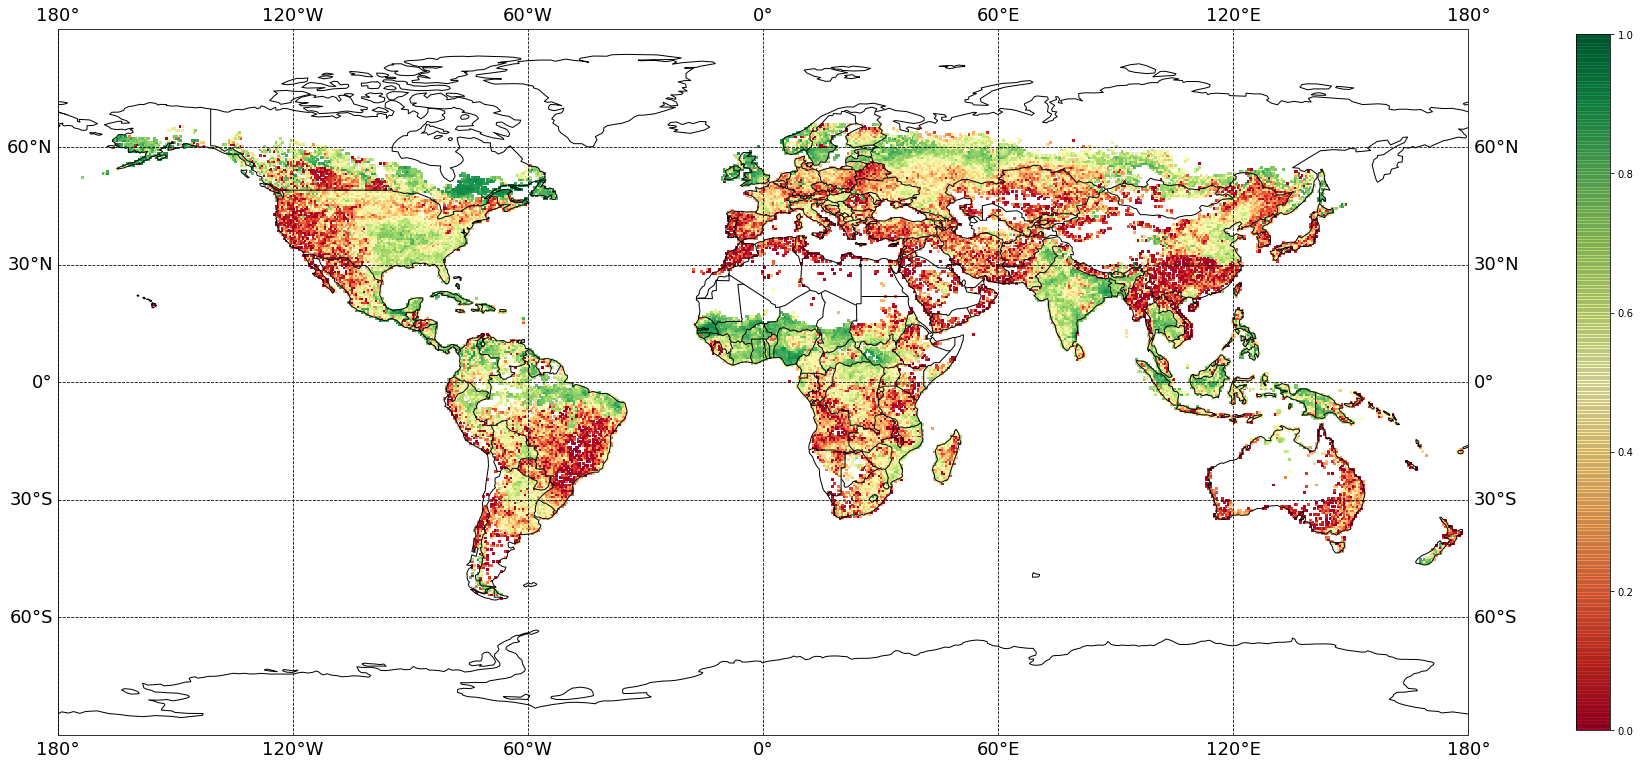

In [54]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = test_score


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=np.arange(0,1.1,.1), cmap=plt.cm.BrBG,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin=0, vmax=1, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Full Score

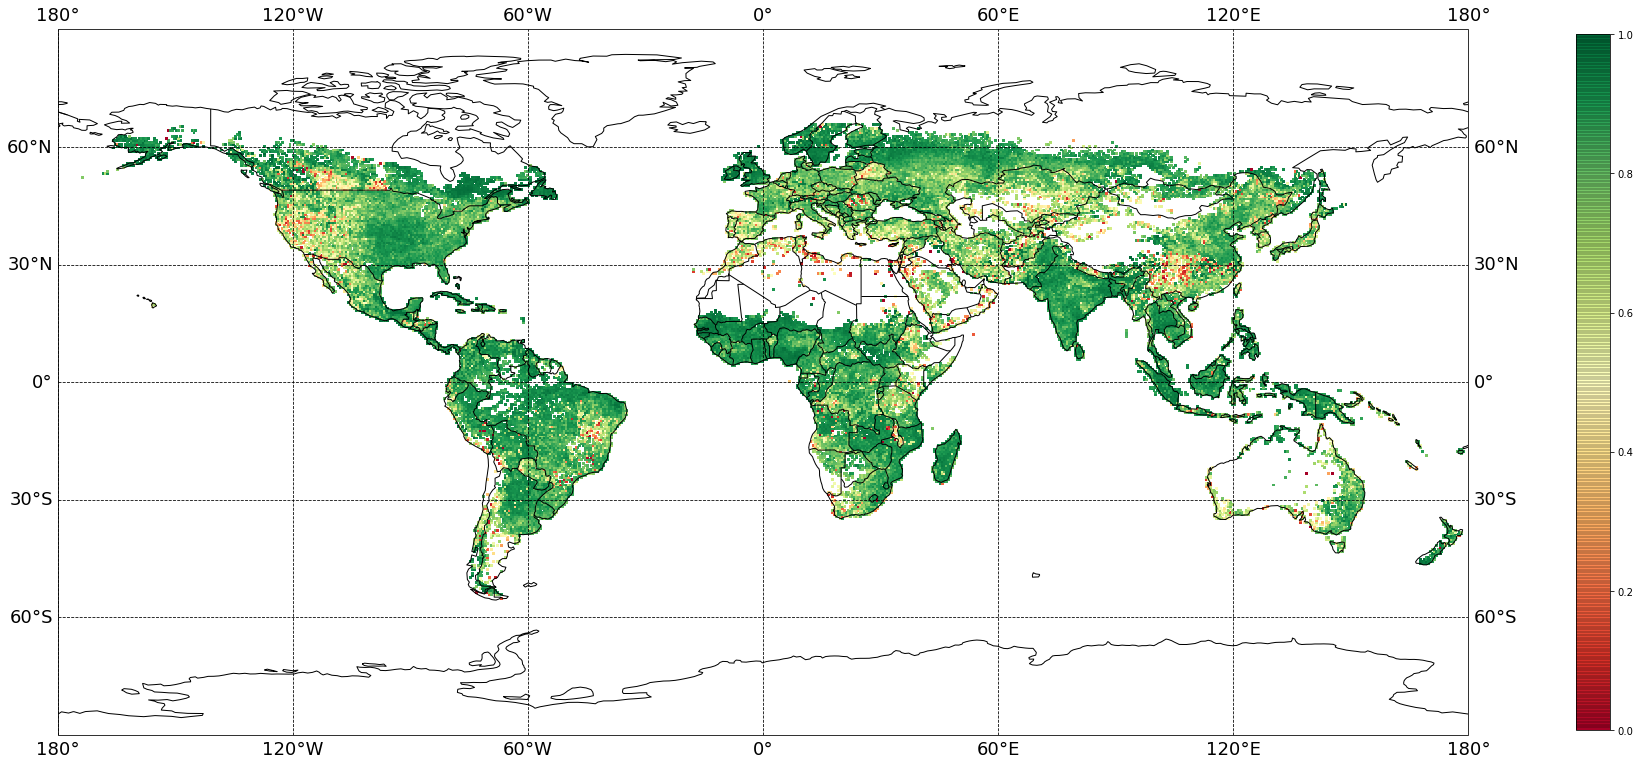

In [55]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = full_score


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=np.arange(0,1.1,.1), cmap=plt.cm.BrBG,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin=0, vmax=1, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Train Score

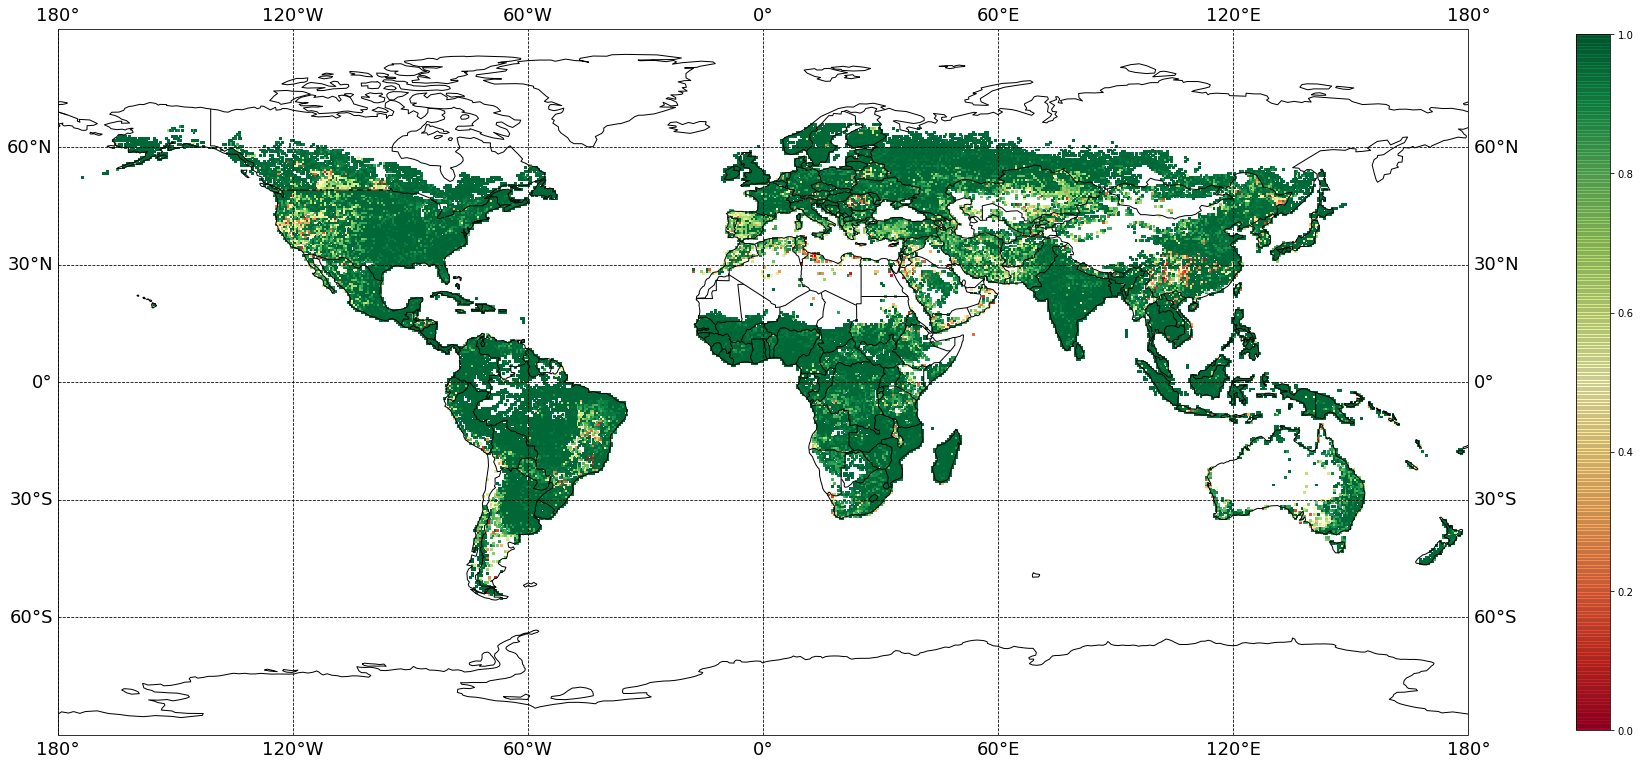

In [56]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = train_score


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=np.arange(0,1.1,.1), cmap=plt.cm.BrBG,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin=0, vmax=1, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



In [48]:
(test_score == full_score).all()

False

In [51]:
(test_score == full_score).all()

False

In [52]:
(train_score == test_score).all()

False

# Yield Means

## Test Yields Mean

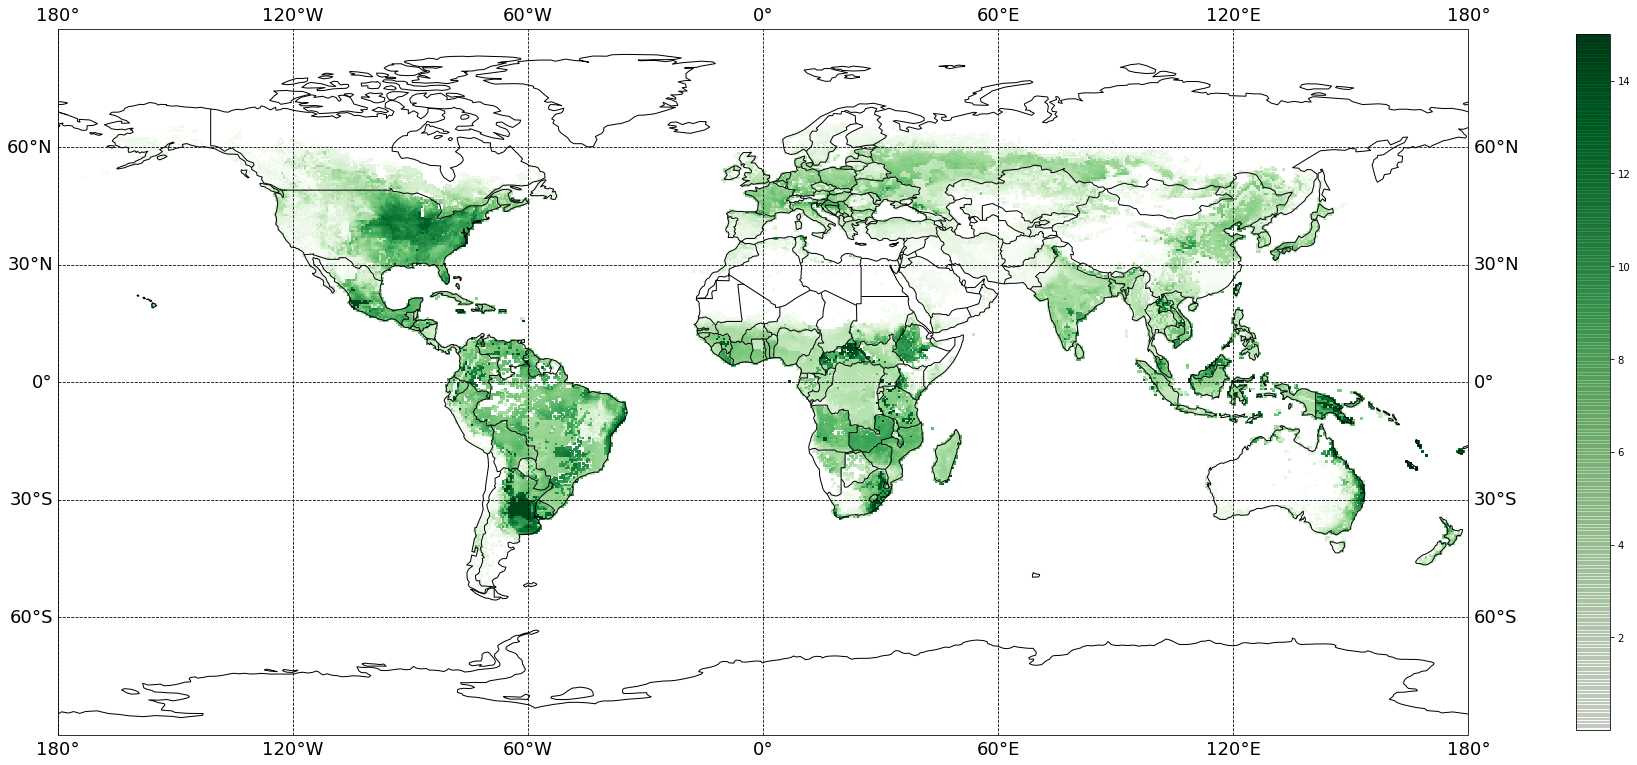

In [63]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = test_yield_mean


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmax=15,cmap=plt.cm.Greens,transform=ccrs.PlateCarree())


#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Full Yield Mean

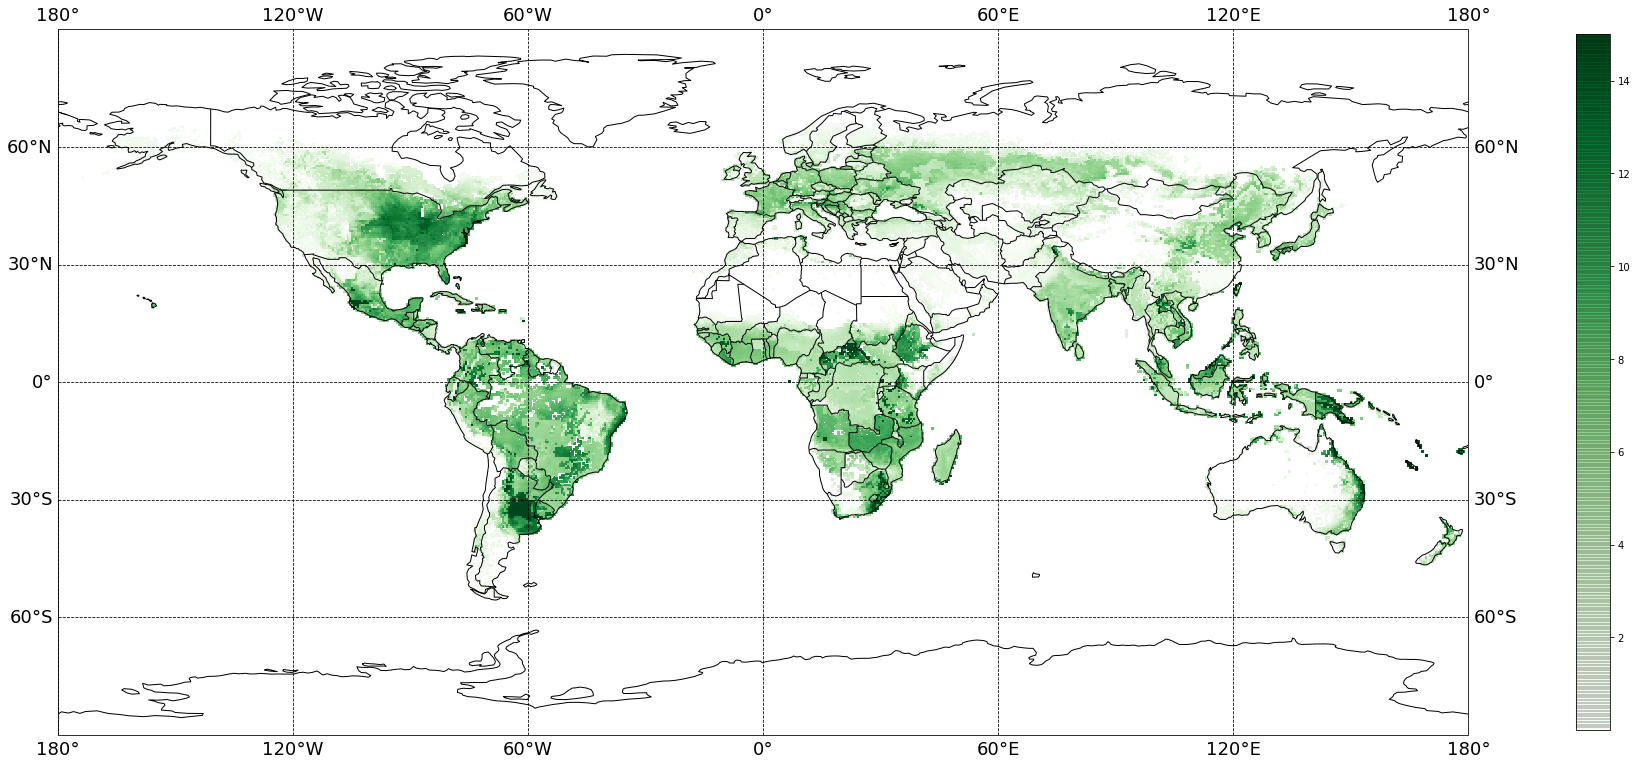

In [64]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = full_yield_mean


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmax=15,cmap=plt.cm.Greens,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Train Yield Mean

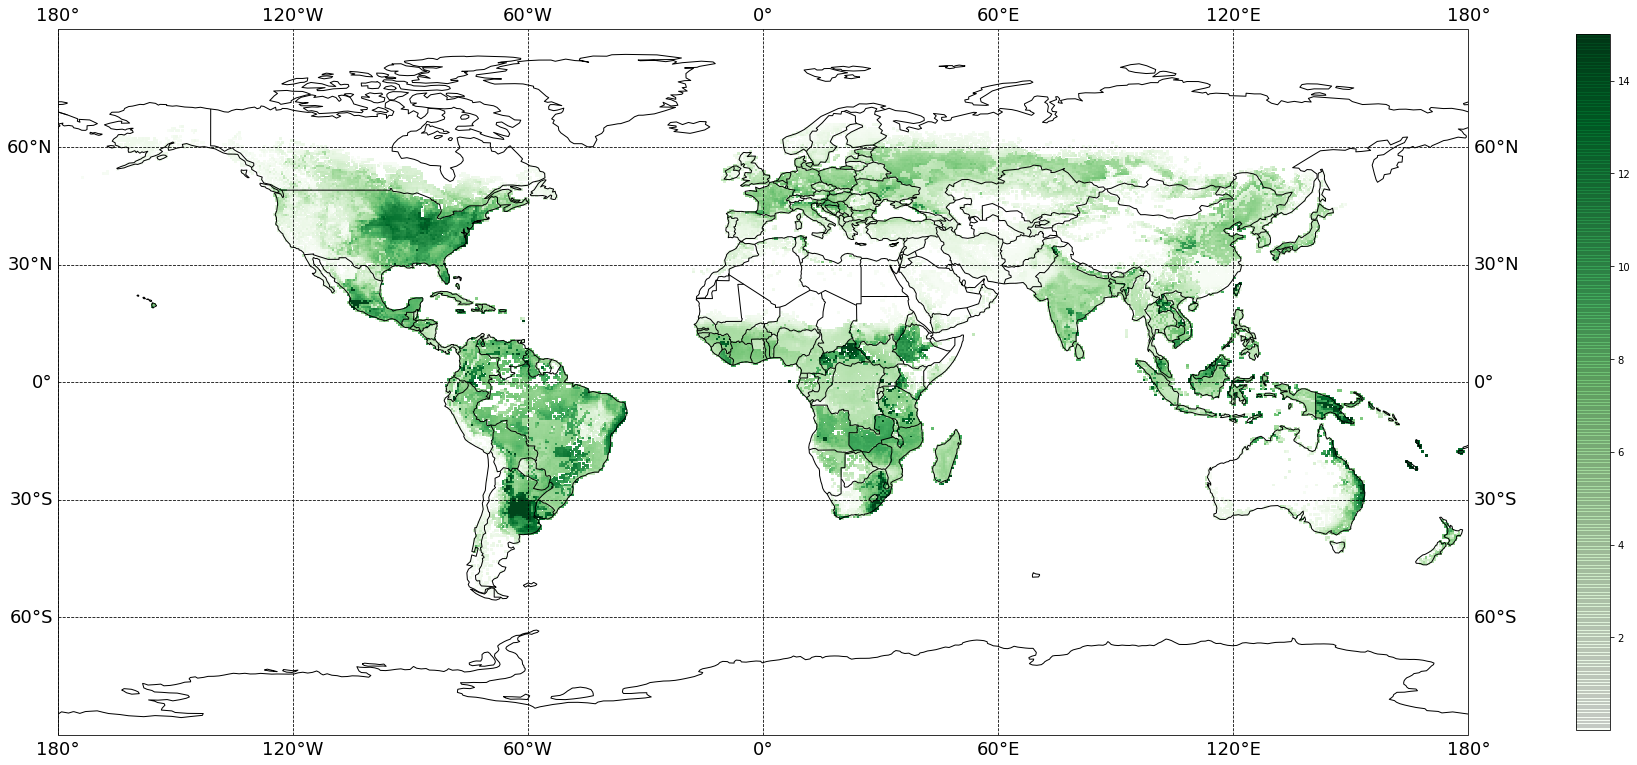

In [65]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = train_yield_mean


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmax=15,cmap=plt.cm.Greens,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



In [38]:
(test_yield_mean == full_yield_mean).all()

False

In [39]:
(test_yield_mean == full_yield_mean).any()

True

In [40]:
np.count_nonzero((test_yield_mean == full_yield_mean))

4864

# Yield Mean Variance

## Test Yields Variance

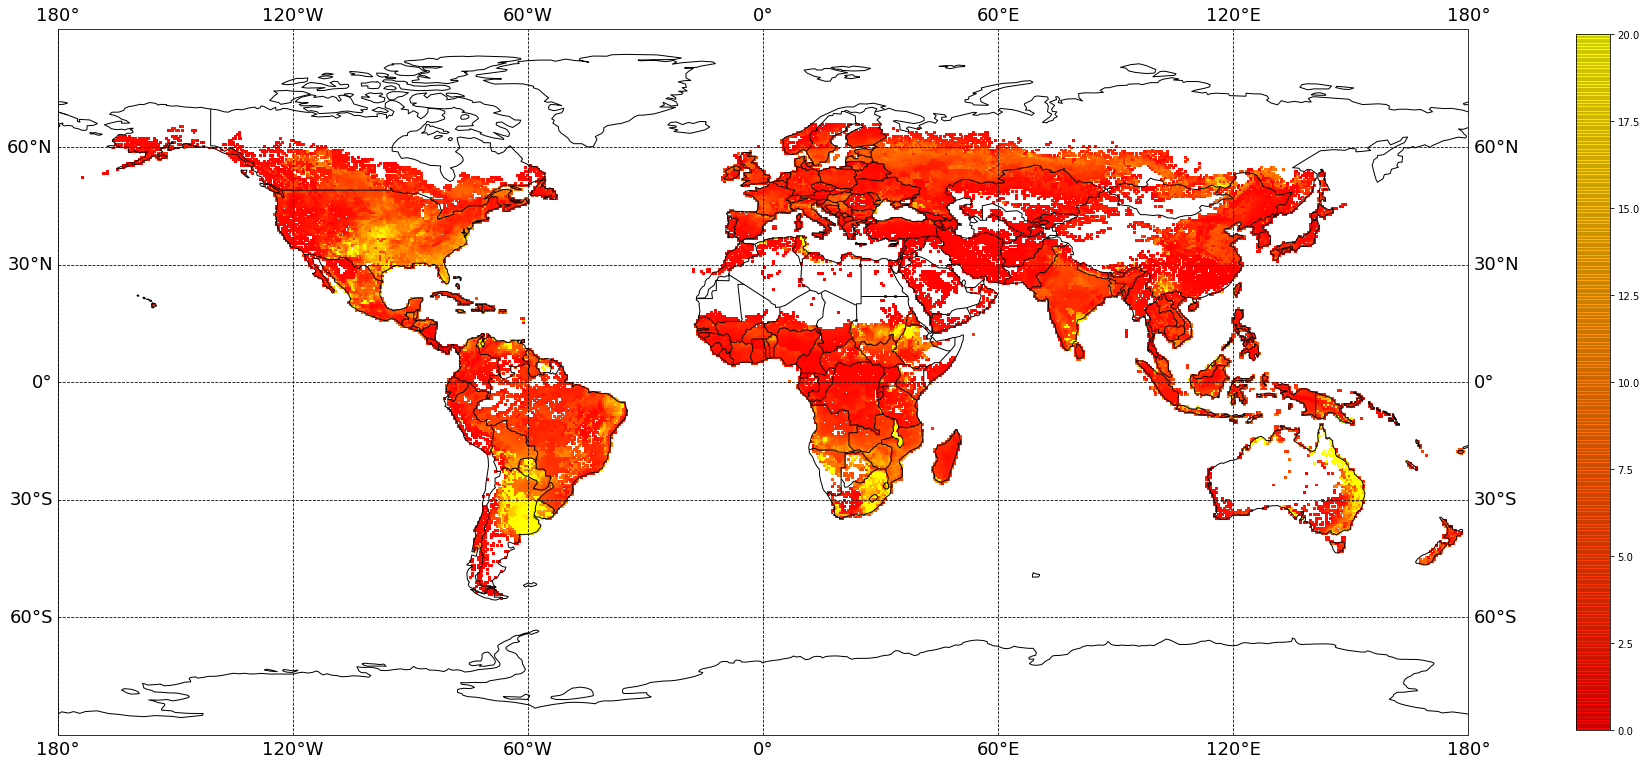

In [67]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = test_yield_mean_variance


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin = 0, vmax = 20, cmap=plt.cm.autumn,transform=ccrs.PlateCarree())


#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Full Yield Variance

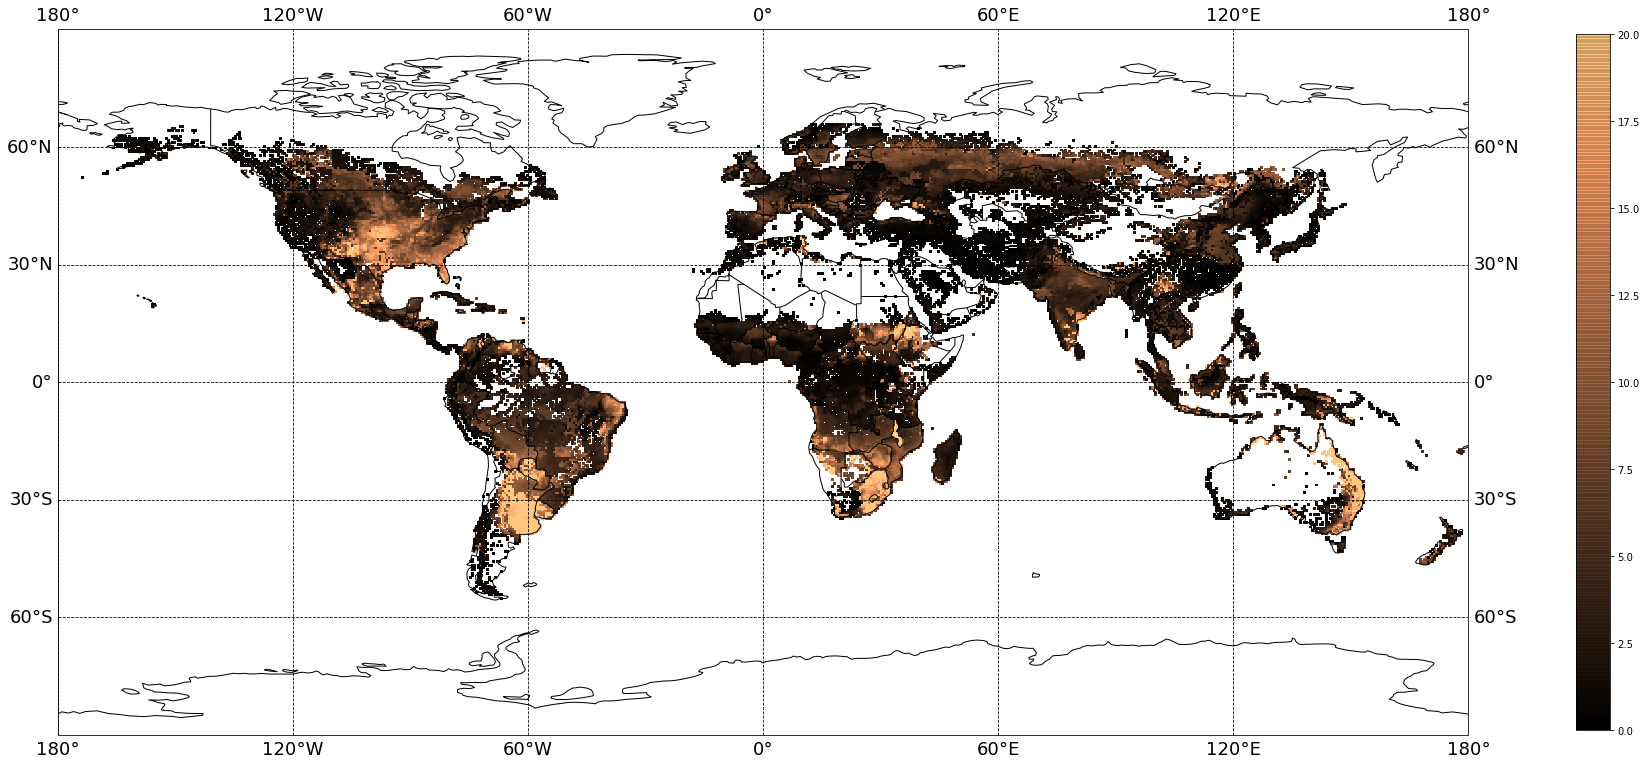

In [70]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = full_yield_variance


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin = 0, vmax = 20, cmap=plt.cm.copper,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



## Train Yield Mean Variance

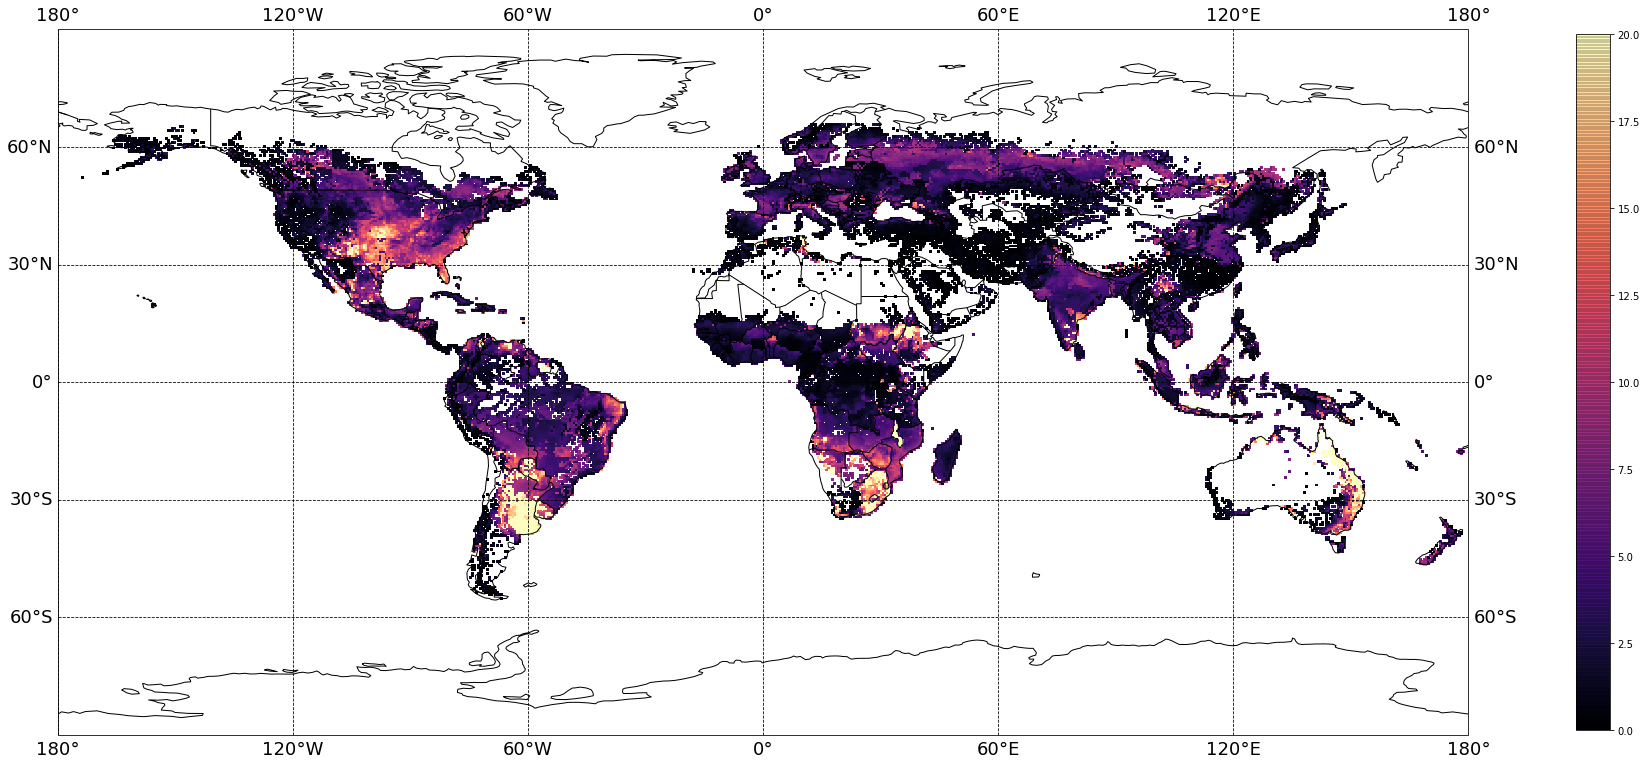

In [71]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = train_yield_mean_variance


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



#plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0),levels=50, cmap=plt.cm.RdYlGn,transform=ccrs.PlateCarree())
plt.pcolormesh(X,np.flip(Y,0), np.flip(datum,axis=0), vmin = 0, vmax = 20, cmap=plt.cm.magma,transform=ccrs.PlateCarree())

#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



# Feature Importance

In [78]:
import matplotlib as mpl
cmap = (mpl.colors.ListedColormap(['deepskyblue','powderblue','lightblue','skyblue','lightskyblue',
                                  'midnightblue','blue','mediumblue','darkblue','navy',
                                  'saddlebrown','linen','peachpuff','sandybrown','chocolate',
                                  'mediumvioletred','thistle','plum','violet','orchid',
                                  'orangered','mistyrose','lightsalmon','salmon','coral',
                                  'darkred','indianred','brown','firebrick','maroon',
                                  'black','silver','darkgrey','darkgray','grey','gray','dimgrey','dimgray']).with_extremes(over='0.15', under='0.85'))
#cmap=plt.cm.tab20c

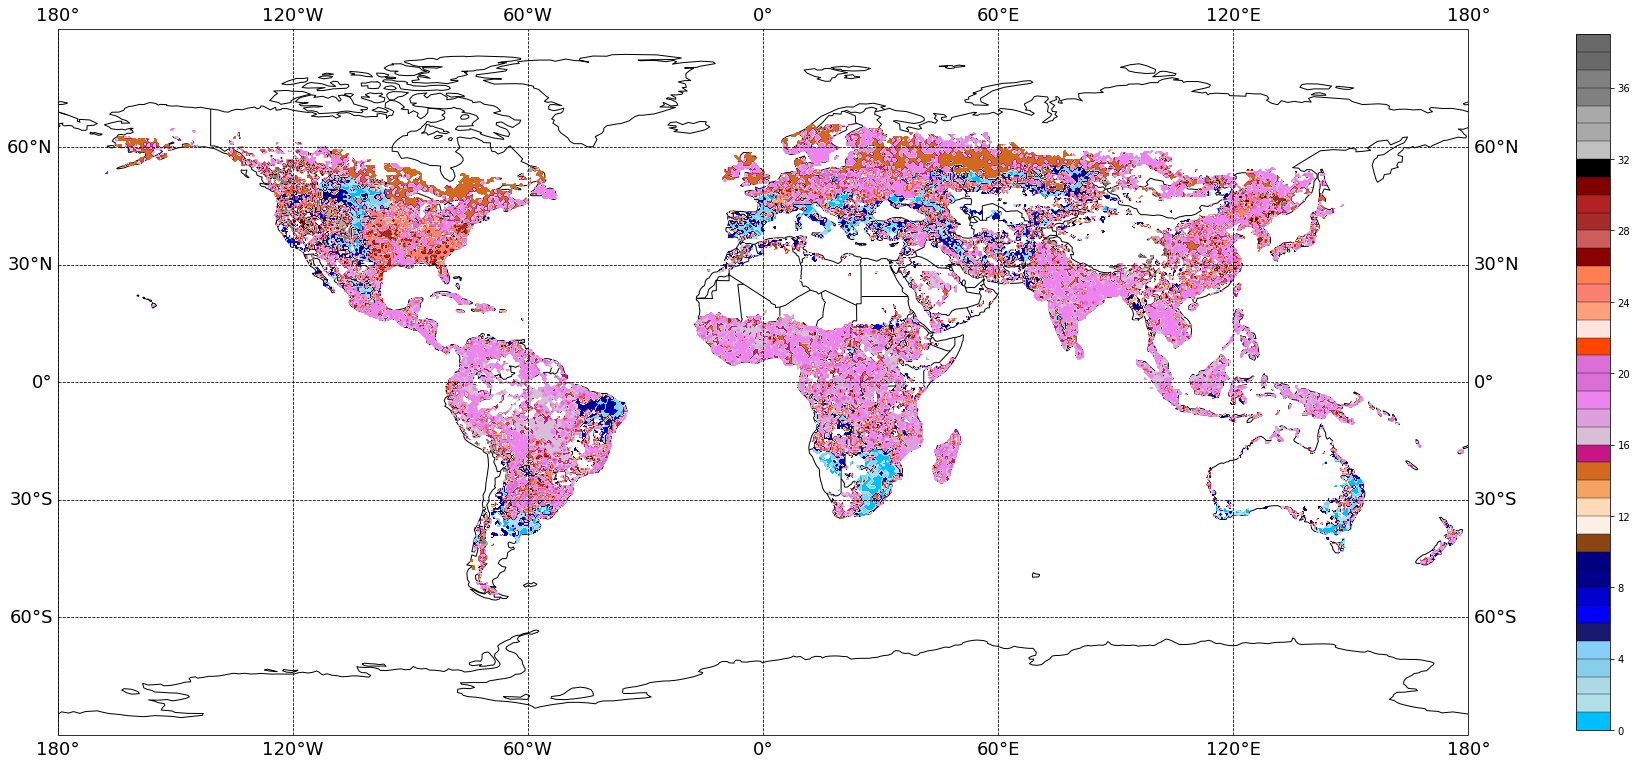

In [79]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}


data = first


datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=40, cmap=cmap,transform=ccrs.PlateCarree())


#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



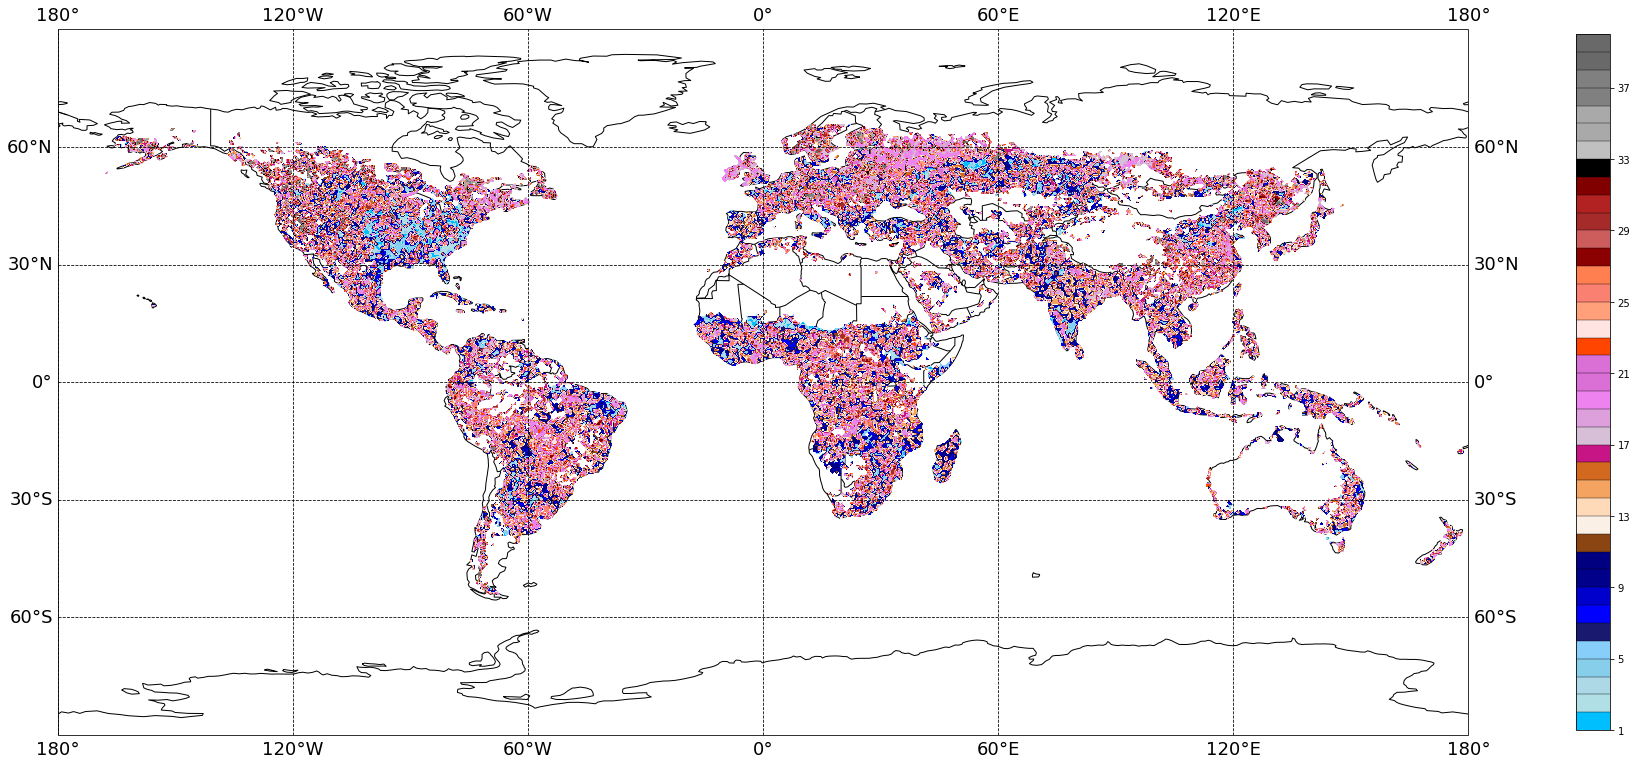

In [80]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}

datum = np.ma.masked_array(second+1, pdssat.variables['yield_mai'][0,:,:].mask)



plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=40,cmap=cmap,transform=ccrs.PlateCarree())


#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



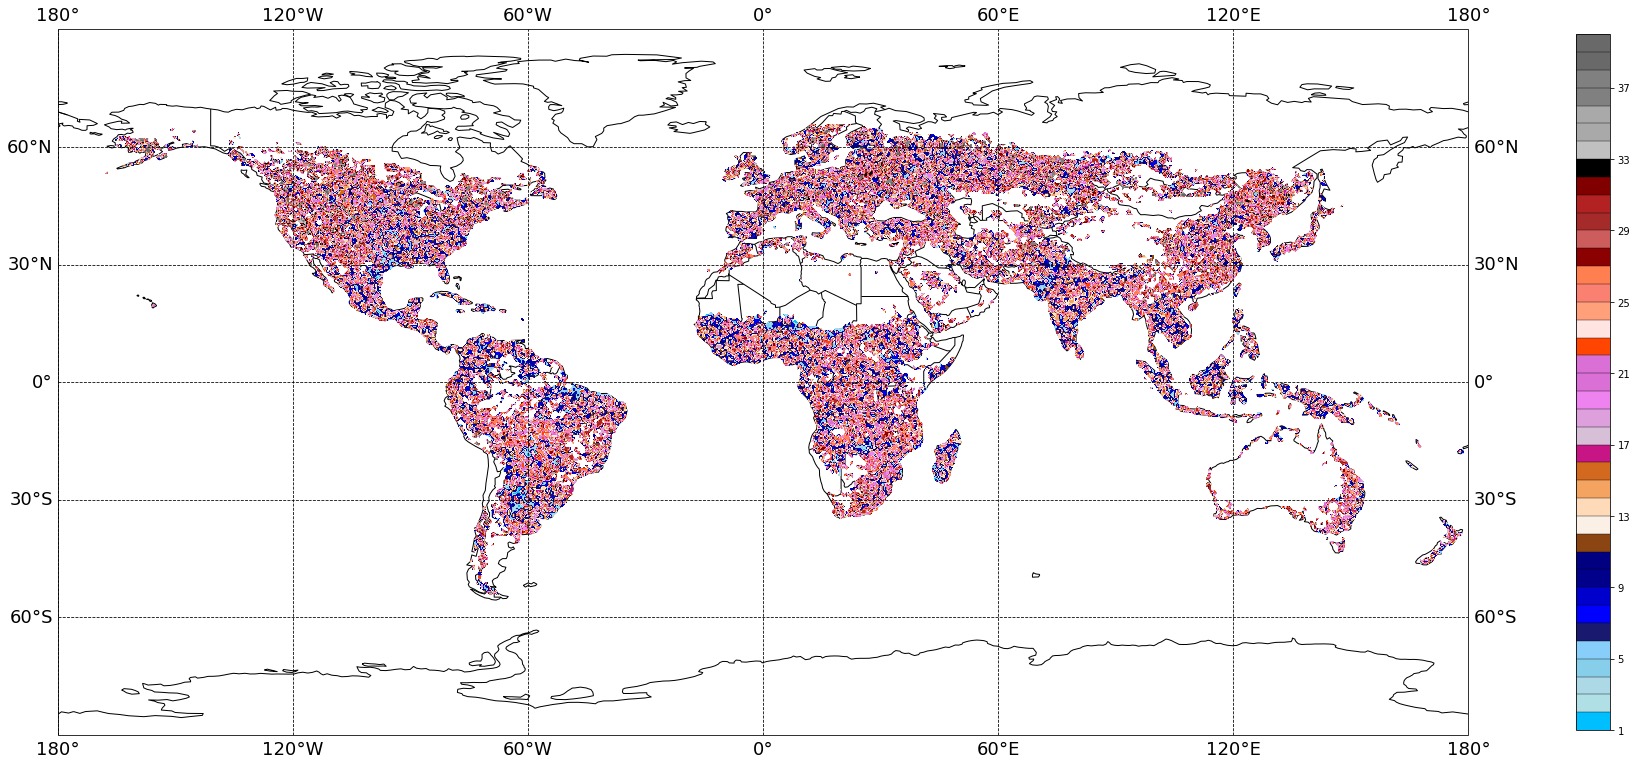

In [81]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(32,16))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent((np.nanmin(self.lons),
 #              np.nanmax(self.lons),
  #            np.nanmin(self.lats),
   #            np.nanmax(self.lats)))
ax.set_global()

ax.coastlines(resolution='110m',
         linewidth=1)
ax.add_feature(cfeature.BORDERS)


gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
gl.xlabel_style = {'size': 18, 'color': 'Black'}
gl.ylabel_style = {'size': 18, 'color': 'Black'}

datum = np.ma.masked_array(third+1, pdssat.variables['yield_mai'][0,:,:].mask)



plt.contourf(X,np.flip(Y,0), np.flip(datum,axis=0), levels=40,cmap=cmap,transform=ccrs.PlateCarree())


#cb = plt.colorbar(ax=ax,
 #                     orientation='horizontal',
  #                    pad=0.06,
   #                   aspect=20,
    #                  shrink = 0.8,
     #                 drawedges=True)
        
cb = plt.colorbar(ax=ax,
                 pad=0.06,
                 aspect=20,
                 shrink=0.8,
                 drawedges=True)



In [ ]:
for i, col in enumerate(this.X.columns):
    print(i,col)

In [ ]:

def map_where(feature):
    
    from cartopy import crs as ccrs
    from cartopy import feature as cfeature

    fig = plt.figure(figsize=(32,16))
    ax = plt.axes(projection=ccrs.PlateCarree())

    #ax.set_extent((np.nanmin(self.lons),
     #              np.nanmax(self.lons),
      #            np.nanmin(self.lats),
       #            np.nanmax(self.lats)))
    ax.set_global()

    ax.coastlines(resolution='110m',
             linewidth=1)
    ax.add_feature(cfeature.BORDERS)


    gl = ax.gridlines(linestyle='--', color='black', draw_labels=True)
    gl.xlabel_style = {'size': 18, 'color': 'Black'}
    gl.ylabel_style = {'size': 18, 'color': 'Black'}


    data = first
    mask = data == FEATURES[feature]
    data = data=mask


    datum = np.ma.masked_array(data, pdssat.variables['yield_mai'][0,:,:].mask)



    plt.contour(X,np.flip(Y,0), np.flip(datum,axis=0), levels=40, transform=ccrs.PlateCarree())
    plt.title(feature)


    #cb = plt.colorbar(ax=ax,
     #                     orientation='horizontal',
      #                    pad=0.06,
       #                   aspect=20,
        #                  shrink = 0.8,
         #                 drawedges=True)

    #cb = plt.colorbar(ax=ax,
     #                pad=0.06,
      #               aspect=20,
       #              shrink=0.8,
        #             drawedges=True)



In [ ]:
map_where('Mean T GS')

In [ ]:
for name in this.X.columns:
    map_where(name)